In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import random

np.random.seed(42)

In [2]:
import math

class ImagePlot:
    def __init__(self, max_columns=5):
        self.reset()
        self.max_columns = max_columns

    def reset(self):
        self.images = []

    def add(self, image, title=""):
        self.images.append({
            "image": image,
            "title": title
        })

    def show(self):
        n_rows = math.ceil(len(self.images) / self.max_columns)
        n_cols = self.max_columns

        plt.figure(figsize=(25, 7))
        for i in range(len(self.images)):
            plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(self.images[i]["image"], cmap="gray")
            plt.title(self.images[i]["title"])
            plt.axis("off")

        plt.show()

plotter = ImagePlot()

In [3]:
data = scipy.io.loadmat("./data/MNIST.mat")
X = data["X"]
Y = data["I"]

In [4]:
print(X.shape)
print(Y.shape)

(256, 1707)
(1, 1707)


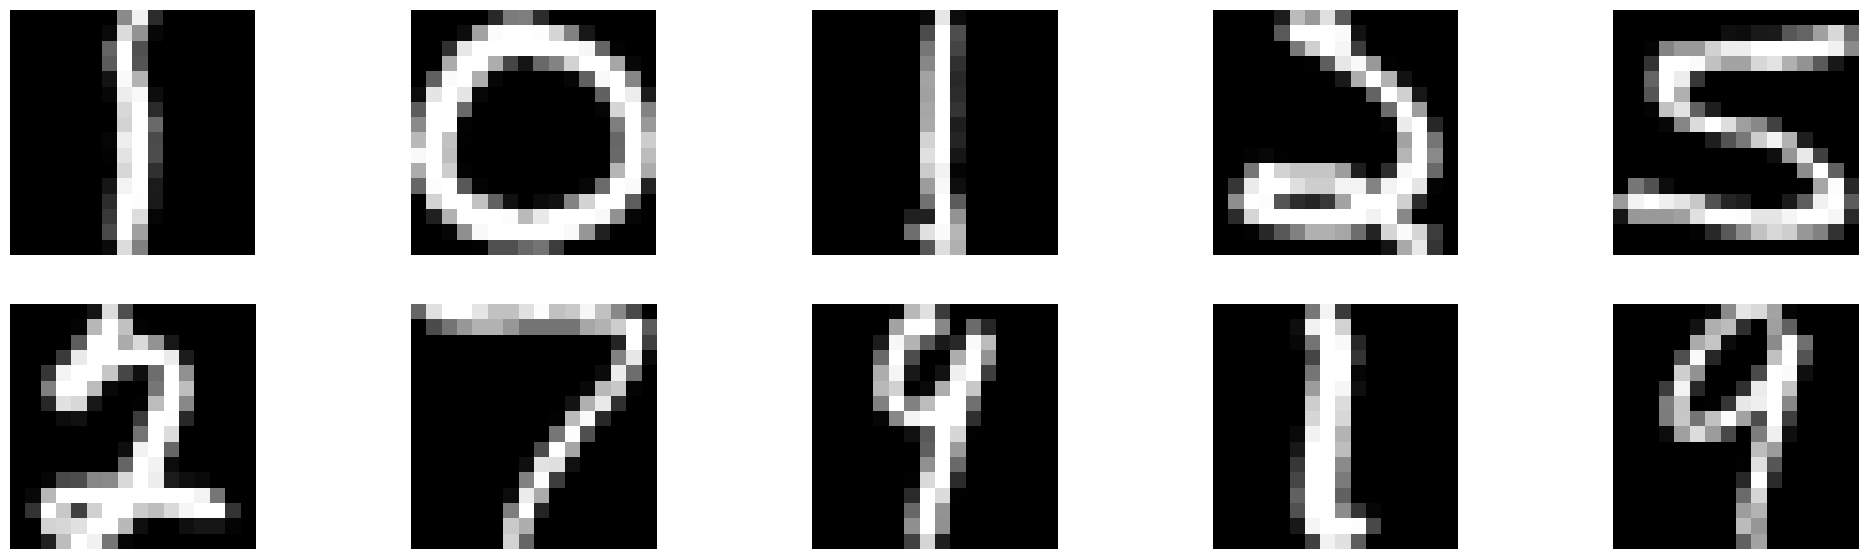

In [5]:
plotter.reset()

for i in [random.randint(0, X.shape[1]) for _ in range(10)]:
    plotter.add(X[:, i].reshape((16, 16)))

plotter.show()

In [6]:
def getImagesOfDigit(digit, X, Y):
    return X[:, (Y[0] == digit)]

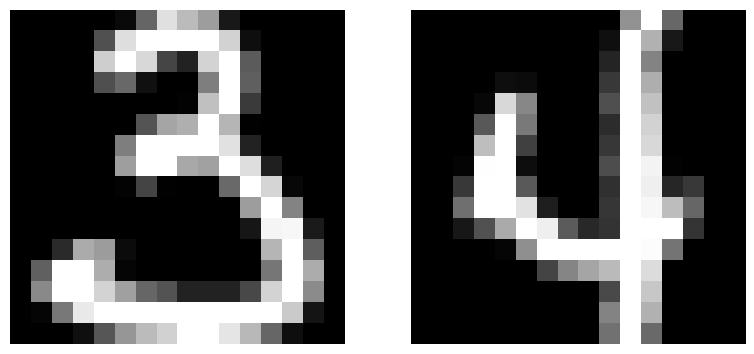

In [7]:
c1 = 3
c2 = 4
X_c1 = getImagesOfDigit(c1, X, Y)
X_c2 = getImagesOfDigit(c2, X, Y)

plotter.reset()
plotter.add(X_c1[:, 0].reshape((16, 16)))
plotter.add(X_c2[:, 0].reshape((16, 16)))
plotter.show()

In [8]:
def split_train_test(X, train_ratio):
    train_size = int(train_ratio * X.shape[1])
    idxs = np.arange(0, X.shape[1])
    np.random.shuffle(idxs)
    return X[:, idxs[:train_size]], X[:, idxs[train_size:]]

In [9]:
X_c1_train, X_c1_test = split_train_test(X_c1, 0.8)
X_c2_train, X_c2_test = split_train_test(X_c2, 0.8)

print(f"X_c1 | train: {X_c1_train.shape} -- test: {X_c1_test.shape}")
print(f"X_c2 | train: {X_c2_train.shape} -- test: {X_c2_test.shape}")

X_c1 | train: (256, 104) -- test: (256, 27)
X_c2 | train: (256, 97) -- test: (256, 25)


In [10]:
class MNISTBinaryClassPredict:
    def __init__(self):
        self.U1, self.c1 = None, None
        self.U2, self.c2 = None, None

    def fit(self, train_set_c1, label_c1, train_set_c2, label_c2):
        U1, _, _ = np.linalg.svd(train_set_c1, full_matrices=False)
        self.U1 = U1
        self.c1 = label_c1

        U2, _, _ = np.linalg.svd(train_set_c2, full_matrices=False)
        self.U2 = U2
        self.c2 = label_c2

    def predict(self, digit):
        y1_proj = self.U1 @ (self.U1.T @ digit)
        y2_proj = self.U2 @ (self.U2.T @ digit)

        dist1 = np.linalg.norm(digit - y1_proj, 2)
        dist2 = np.linalg.norm(digit - y2_proj, 2)

        if dist1 < dist2:
            return self.c1
        else:
            return self.c2


def evaluate(model, dataset, true_label):
    correct = 0
    for i in range(dataset.shape[1]):
        if model.predict(dataset[:, i]) == true_label:
            correct += 1
    return correct

In [21]:
c1 = 0
c2 = 8
X_c1 = getImagesOfDigit(c1, X, Y)
X_c2 = getImagesOfDigit(c2, X, Y)
X_c1_train, X_c1_test = split_train_test(X_c1, 0.7)
X_c2_train, X_c2_test = split_train_test(X_c2, 0.7)


model = MNISTBinaryClassPredict()
model.fit(X_c1_train, c1, X_c2_train, c2)

c1_correct = evaluate(model, X_c1_test, c1)
c2_correct = evaluate(model, X_c2_test, c2)

print(f"Accuracy ({c1}): {c1_correct / X_c1_test.shape[1]:.3f} ({X_c1_test.shape[1]-c1_correct}/{X_c1_test.shape[1]} wrong)")
print(f"Accuracy ({c2}): {c2_correct / X_c2_test.shape[1]:.3f} ({X_c2_test.shape[1]-c2_correct}/{X_c2_test.shape[1]} wrong)")

Accuracy (0): 1.000 (0/96 wrong)
Accuracy (8): 0.023 (43/44 wrong)


In [12]:
class MNISTMultiClassPredict:
    def __init__(self):
        self.U_n = {}

    def fit(self, digits_train_sets, digits_train_labels):
        for dataset, label in zip(digits_train_sets, digits_train_labels):
            U, _, _ = np.linalg.svd(dataset, full_matrices=False)
            self.U_n[label] = U

    def predict(self, digit):
        best_dist = +np.inf
        prediction = None

        for label in self.U_n:
            U = self.U_n[label]
            proj = U @ (U.T @ digit)

            dist = np.linalg.norm(digit - proj, 2)
            if dist < best_dist:
                best_dist = dist
                prediction = label

        return prediction

In [13]:
to_train_digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_sets = []
test_sets = []

for digit in to_train_digits:
    train, test = split_train_test(X[:, (Y[0] == digit)], 0.7)
    train_sets.append(train)
    test_sets.append(test)

model = MNISTMultiClassPredict()
model.fit(train_sets, to_train_digits)

for label, test_set in zip(to_train_digits, test_sets):
    correct = evaluate(model, test_set, label)
    print(f"{label} | Accuracy: {correct / test_set.shape[1]:.3f} ({test_set.shape[1]-correct}/{test_set.shape[1]} wrong)")

0 | Accuracy: 1.000 (0/96 wrong)
1 | Accuracy: 1.000 (0/76 wrong)
2 | Accuracy: 0.246 (46/61 wrong)
3 | Accuracy: 0.000 (40/40 wrong)
4 | Accuracy: 0.027 (36/37 wrong)
5 | Accuracy: 0.000 (27/27 wrong)
6 | Accuracy: 0.043 (44/46 wrong)
7 | Accuracy: 0.560 (22/50 wrong)
8 | Accuracy: 0.000 (44/44 wrong)
9 | Accuracy: 0.150 (34/40 wrong)
